In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks

openbci_datapath = '/home/hxiong/Desktop/Research/Galea/data/OpenBCI_data/2024-10-24-tianwen-11tests/OpenBCISession_2024-10-24_tianwen_11tests/OpenBCI-RAW-2024-10-24_15-18-27.txt'
sample_rate = 125
data_raw = pd.read_csv(openbci_datapath, sep=",", header=6, index_col=False, names=["Sample Index", "ch0", "ch1", "ch2", "ch3", "ch4", "ch5", "ch6", "ch7", "ch8", "ch9", "ch10", "ch11", "ch12", "ch13", "ch14", "ch15", "Accel Channel 0", "Accel Channel 1", "Accel Channel 2", "Not Used", "Digital Channel 0 (D11)", "Digital Channel 1 (D12)", "Digital Channel 2 (D13)", "Digital Channel 3 (D17)", "Not Used 2", "Digital Channel 4 (D18)", "Analog Channel 0", "Analog Channel 1", "Analog Channel 2", "Timestamp", "Marker", "Timestamp (Formatted)"])
data_raw.drop(labels = ['Not Used','Not Used 2'], inplace = True, axis = 1)
# data_raw = data_raw[:][10*sample_rate:] #treat the first 20 seconds as noise, remove
data_raw.reset_index(inplace=True, drop=True)
print("OpenBCI data shape: ", data_raw.shape)
print(data_raw.columns)

OpenBCI data shape:  (17051, 31)
Index(['Sample Index', 'ch0', 'ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6', 'ch7',
       'ch8', 'ch9', 'ch10', 'ch11', 'ch12', 'ch13', 'ch14', 'ch15',
       'Accel Channel 0', 'Accel Channel 1', 'Accel Channel 2',
       'Digital Channel 0 (D11)', 'Digital Channel 1 (D12)',
       'Digital Channel 2 (D13)', 'Digital Channel 3 (D17)',
       'Digital Channel 4 (D18)', 'Analog Channel 0', 'Analog Channel 1',
       'Analog Channel 2', 'Timestamp', 'Marker', 'Timestamp (Formatted)'],
      dtype='object')


In [2]:
Timestamps = (data_raw['Timestamp'].to_numpy() - data_raw['Timestamp'].to_numpy()[0])
print("Timestamps shape: ", Timestamps.shape)
print("Start Time(PST):", data_raw["Timestamp (Formatted)"][0])
print("End Time(PST):", data_raw["Timestamp (Formatted)"].iloc[-1])
print("Total length of data: ", Timestamps[-1], 's')


Timestamps shape:  (17051,)
Start Time(PST):  2024-10-24 15:18:27.547
End Time(PST):  2024-10-24 15:20:43.817
Total length of data:  136.26986479759216 s


In [3]:
def plot_EEG_vs_time(data, rescale=False, title="EEG Signal vs Time"):
    # plot EEG signals, if rescale set to True, all the signls are divided by their mean
    data = data.copy()
    data = np.array(data)
    print("EEG data shape: ", data.shape)
    plt.figure(figsize=(10, 6))
    if len(data.shape) == 1:
        if rescale:
            plt.plot(data/np.mean(data), label = 'ch')
        else:
            plt.plot(data,label=f'ch')
    else:
        if rescale:
            for i in range(data.shape[1]):
                plt.plot(data[:,i]/np.mean(data[:,i])+i, label = 'ch'+str(i+1))
        else:
            for i in range(data.shape[1]):
                plt.plot(data[:,i],label=f'ch{i+1}')
                

    plt.legend(loc="upper right",bbox_to_anchor=(1.15, 1.0), fontsize='small', ncol=1)
    plt.title(title)
    plt.ylabel("voltage (micro volt)")
    try:
        plt.xticks(ticks=np.arange(0, round((Timestamps[-1]+1)*sample_rate), round((Timestamps[-1]+1)*sample_rate/10)), 
            labels=np.arange(0, round(Timestamps[-1]+1),round((Timestamps[-1]+1)/10)))
    except:
        print("incorrectxtick setup!")
    plt.xlabel('time (s)')
    plt.show()

EEG data shape:  (17051, 16)


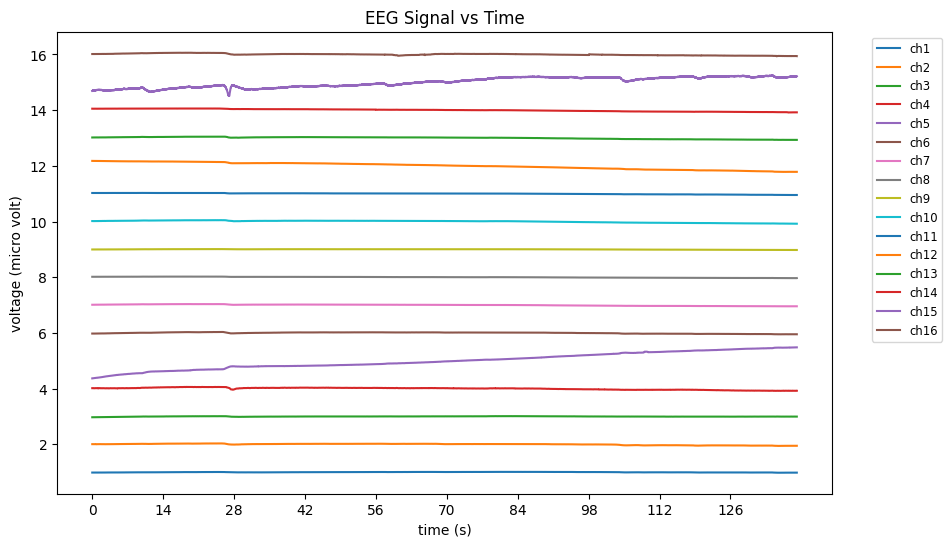

In [4]:
EEG_data_raw = data_raw[['ch0', 'ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6', 'ch7',
       'ch8', 'ch9', 'ch10', 'ch11', 'ch12', 'ch13', 'ch14', 'ch15',]].to_numpy()

plot_EEG_vs_time(EEG_data_raw, rescale=True)

# Reading Data using Brainflow

In [5]:
from brainflow.board_shim import BoardShim, BrainFlowInputParams, LogLevels, BoardIds
from brainflow.data_filter import WindowOperations,DetrendOperations, DataFilter, NoiseTypes, FilterTypes, AggOperations, WaveletTypes, NoiseEstimationLevelTypes, WaveletExtensionTypes, ThresholdTypes, WaveletDenoisingTypes
import time
BoardShim.enable_dev_board_logger()

# use synthetic board for demo
params = BrainFlowInputParams()
board = BoardShim(BoardIds.SYNTHETIC_BOARD.value, params)
board.prepare_session()
board.start_stream()
nfft = DataFilter.get_nearest_power_of_two(sample_rate)
BoardShim.log_message(LogLevels.LEVEL_INFO.value, 'start sleeping in the main thread')
time.sleep(1)
data = board.get_board_data()
board.stop_stream()
board.release_session()

# Read Dataset
eeg_channels = list(range(0,16))
df = pd.DataFrame(EEG_data_raw)
print('Data From the Board')

[2024-11-07 18:57:48.625] [board_logger] [info] incoming json: {
    "file": "",
    "file_anc": "",
    "file_aux": "",
    "ip_address": "",
    "ip_address_anc": "",
    "ip_address_aux": "",
    "ip_port": 0,
    "ip_port_anc": 0,
    "ip_port_aux": 0,
    "ip_protocol": 0,
    "mac_address": "",
    "master_board": -100,
    "other_info": "",
    "serial_number": "",
    "serial_port": "",
    "timeout": 0
}
[2024-11-07 18:57:48.625] [board_logger] [trace] Board object created -1
[2024-11-07 18:57:48.626] [board_logger] [info] start sleeping in the main thread


Data From the Board


# Filtering using Brainflow

EEG data shape:  (17051, 16)


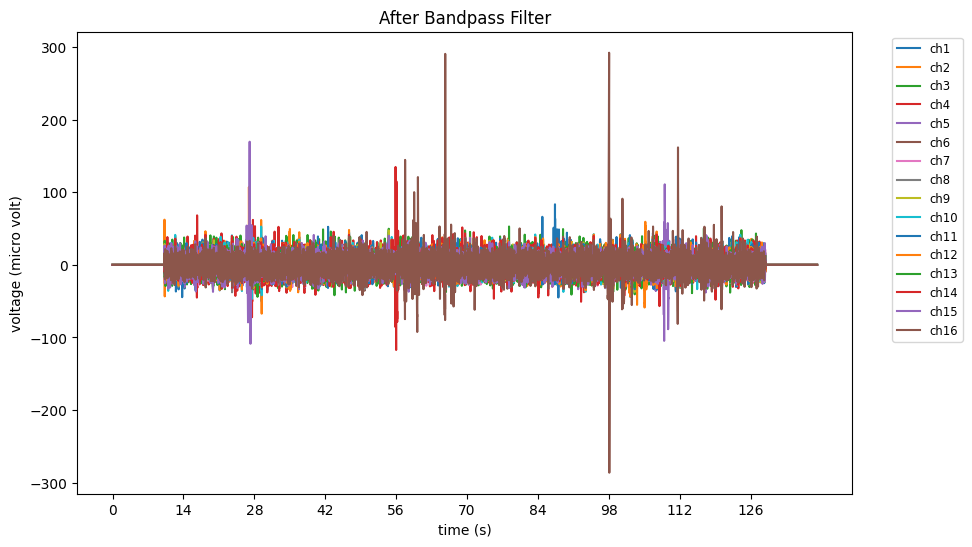

In [6]:
EEG_data_filtered = df.copy()  
EEG_data_filtered= np.array(EEG_data_filtered)
# for demo apply different filters to different channels, in production choose one
for count, channel in enumerate(eeg_channels):
    # # filters work in-place
    # if count == 0:
    #     DataFilter.perform_bandpass(EEG_data_filtered[channel], sample_rate, 2.0, 50.0, 4,
    #                                 FilterTypes.BESSEL_ZERO_PHASE, 0)
    # elif count == 1:
    #     DataFilter.perform_bandstop(EEG_data_filtered[channel], sample_rate, 48.0, 52.0, 3,
    #                                 FilterTypes.BUTTERWORTH_ZERO_PHASE, 0)
    # elif count == 2:
    #     DataFilter.perform_lowpass(EEG_data_filtered[channel], sample_rate, 50.0, 5,
    #                                 FilterTypes.CHEBYSHEV_TYPE_1_ZERO_PHASE, 1)
    # elif count == 3:
    #     DataFilter.perform_highpass(EEG_data_filtered[channel], sample_rate, 2.0, 4,
    #                                 FilterTypes.BUTTERWORTH, 0)
    # elif count == 4:
    #     DataFilter.perform_rolling_filter(EEG_data_filtered[channel], 3, AggOperations.MEAN.value)
    # else:
    #     DataFilter.remove_environmental_noise(EEG_data_filtered[channel], sample_rate,
    #                                             NoiseTypes.FIFTY.value)
    DataFilter.perform_bandpass(EEG_data_filtered[:,channel], sample_rate, 2.0, 50.0, 4, FilterTypes.BUTTERWORTH_ZERO_PHASE, 0)


# Delete first and last 10 seconds
EEG_data_filtered[:10*sample_rate] = 0
EEG_data_filtered[-10*sample_rate:] = 0

plot_EEG_vs_time(EEG_data_filtered, rescale = False, title='After Bandpass Filter')



# Denoising using Brainflow

EEG data shape:  (17051, 16)


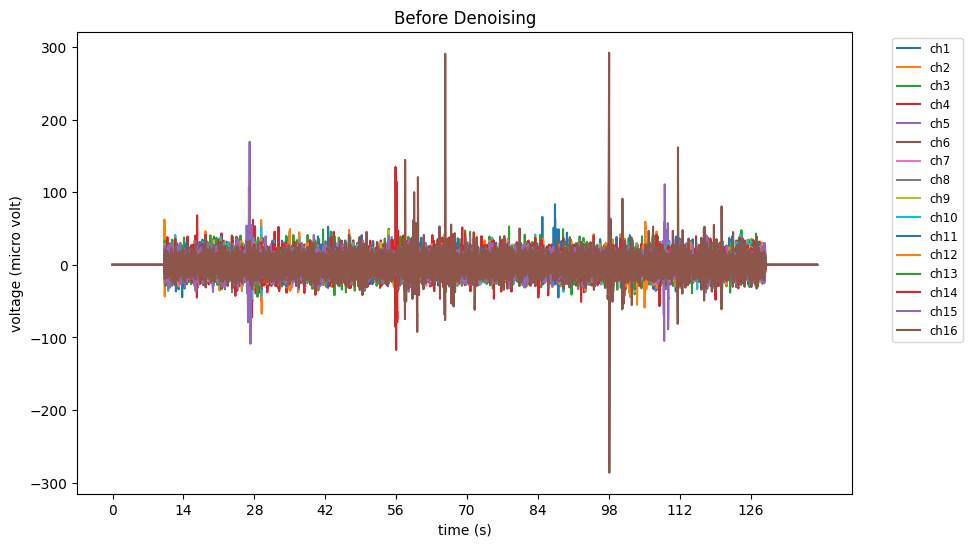

In [7]:
EEG_data_test = EEG_data_filtered.copy()
EEG_data_test = np.ascontiguousarray(EEG_data_test)
plot_EEG_vs_time(EEG_data_test,title="Before Denoising")


EEG data shape:  (17051, 16)


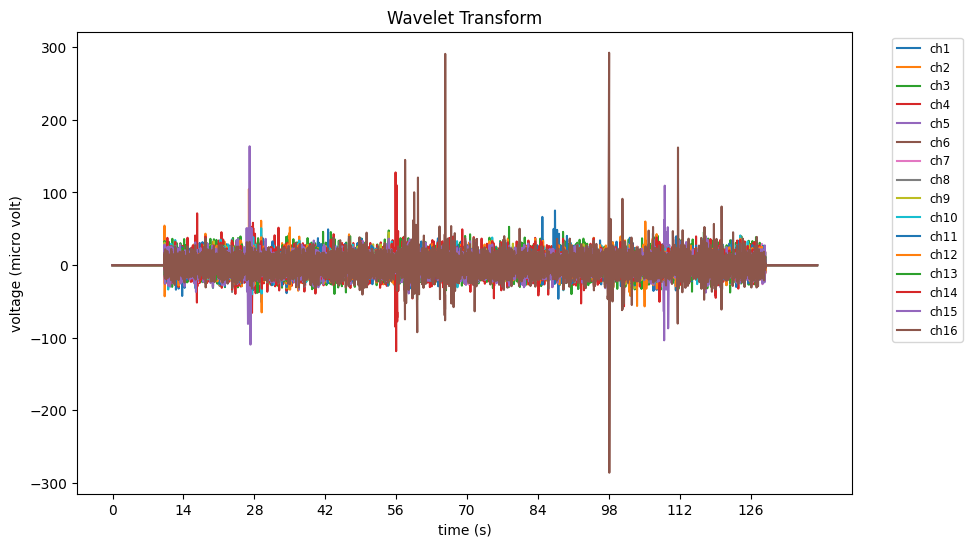

In [8]:
EEG_data_wavelet = np.array(EEG_data_filtered.copy())
# Wavelet Denosing
for count, channel in enumerate(eeg_channels):
    current_channel = np.ascontiguousarray(EEG_data_wavelet[:,channel])
    DataFilter.perform_wavelet_denoising(current_channel, WaveletTypes.BIOR3_9, 5,
                                            WaveletDenoisingTypes.SURESHRINK, ThresholdTypes.HARD,
                                            WaveletExtensionTypes.SYMMETRIC, NoiseEstimationLevelTypes.FIRST_LEVEL)
    EEG_data_wavelet[:,channel] = current_channel

plot_EEG_vs_time(EEG_data_wavelet, title="Wavelet Transform")

EEG data shape:  (17051, 16)


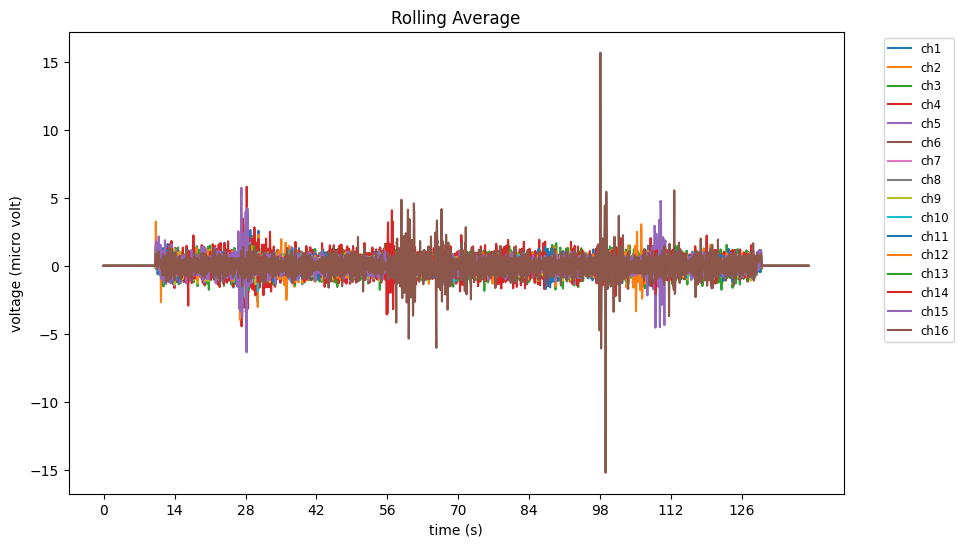

In [9]:
# Rolliong Average
EEG_data_avg = EEG_data_test.copy()
EEG_data_avg = np.array(EEG_data_avg)
for count, channel in enumerate(eeg_channels):
    current_channel = np.ascontiguousarray(EEG_data_avg[:,channel])
    DataFilter.perform_rolling_filter(current_channel, 125, AggOperations.MEAN.value)
    EEG_data_avg[:,channel] = current_channel

plot_EEG_vs_time(EEG_data_avg, title='Rolling Average')

# EEG power band

In [10]:
## Single Channel Band Power
# power_band_test = np.array(EEG_data_filtered[0].copy())
# DataFilter.detrend(power_band_test, DetrendOperations.LINEAR.value)
# psd = DataFilter.get_psd_welch(power_band_test, nfft, nfft // 2, sample_rate, WindowOperations.HANNING.value)
# plt.plot(psd[1], psd[0])
# plt.show()

In [11]:
def get_band_power(data):
    # Return the power spectral density using the Welsh method 
    # Input: EEG data (entries x channels)
    # Output: band power by channel and corresponding frequencies
    for i in eeg_channels:
        current_channel = np.ascontiguousarray(data[:,i])
        DataFilter.detrend(current_channel, DetrendOperations.LINEAR.value)
        data[:,i] = current_channel
    band_power_list = list()
    freq_range_list = list()
    for i in eeg_channels:
        current_channel = np.ascontiguousarray(data[:,i])
        band_power, freq_range = DataFilter.get_psd_welch(current_channel, nfft, nfft // 2, sample_rate, WindowOperations.HANNING.value)
        band_power_list.append(band_power)
        freq_range_list.append(freq_range)

    band_power_list = np.array(band_power_list)
    freq_range_list = np.array(freq_range_list)
    return band_power_list, freq_range_list

In [12]:
power_band_test = EEG_data_filtered.copy()
power_band_test = np.ascontiguousarray(power_band_test)
# print(power_band_test.shape)
band_power_list, freq_range_list = get_band_power(power_band_test)

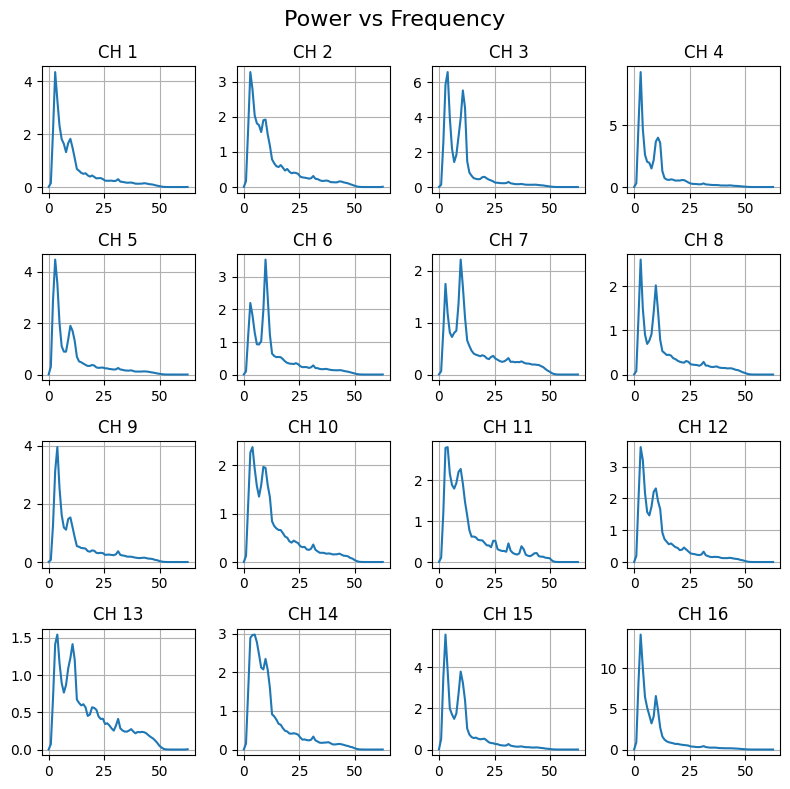

Channel 1:
Alpha (Relaxed wakefulness): 6.080353465129215
Beta (Cognitive Activity): 3.2503699565479987
Delta (Sleep): 10.795543088778267
Theta (Drowsiness): 6.593764072185037


In [13]:
fig, axs = plt.subplots(4, 4, figsize=(8, 8))

cc = 0
for i in range(4):
    for j in range(4):
        axs[i, j].plot(freq_range_list[cc], band_power_list[cc])
        axs[i, j].set_title(f'CH {cc+1}')
        axs[i, j].grid()
        cc += 1

fig.suptitle('Power vs Frequency', fontsize=16)
plt.tight_layout()
plt.show()
psd = (band_power_list[0], freq_range_list[0])
alpha = DataFilter.get_band_power(psd, 8.0, 13.0)
beta = DataFilter.get_band_power(psd, 13.0, 20.0)
delta = DataFilter.get_band_power(psd, 0.0, 4.0)
theta = DataFilter.get_band_power(psd, 4.0, 8.0)
print('Channel 1:')
print('Alpha (Relaxed wakefulness):',alpha)
print('Beta (Cognitive Activity):',beta)
print('Delta (Sleep):',delta)
print('Theta (Drowsiness):',theta)

# Break down signal strength by timewindow

## By fixed windows

In [ ]:
single_channel

(17051,)


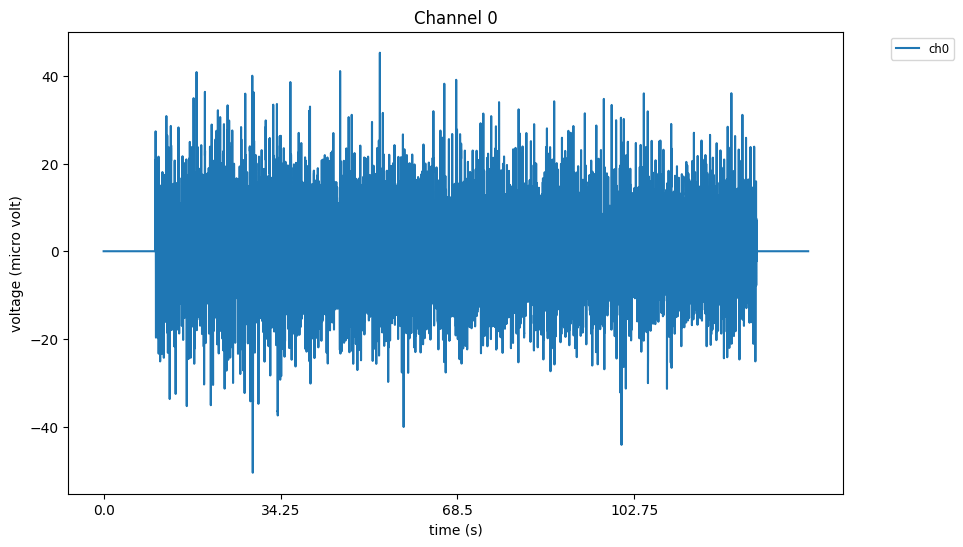

In [15]:
EEG_window = EEG_data_filtered.copy()
channel_id = 0
single_channel = EEG_window[:,channel_id]

print(single_channel.shape)



In [ ]:


plt.figure(figsize=(10, 6))

plt.plot(single_channel,label=f'ch{channel_id}')
plt.legend(loc="upper right",bbox_to_anchor=(1.15, 1.0), fontsize='small', ncol=1)
plt.xticks(ticks=np.arange(0, round(Timestamps[-1]+1)*sample_rate, round(Timestamps[-1]+1)*sample_rate/4), 
           labels=np.arange(0, round(Timestamps[-1]+1),round(Timestamps[-1]+1)/4))
plt.title(f"Channel {channel_id}")
plt.ylabel("voltage (micro volt)")
plt.xlabel("time (s)")
plt.show()